In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/mitangshu11/indian-roads-dataset'
od.download(dataset_url)

Skipping, found downloaded files in "./indian-roads-dataset" (use force=True to force download)


In [ ]:
import os

DATA_DIR = './indian-roads-dataset'
print(os.listdir(DATA_DIR))

['Dataset3Class']


In [ ]:
print(os.listdir(DATA_DIR+'/Dataset3Class/')[:10])

['UnPavedRoad__456.txt', 'PotHoles_782.jpg', 'PotHoles_10.jpg', 'UnPavedRoad__270.jpg', 'UnPavedRoad__880.txt', 'UnMarkedBump_222.jpg', 'UnPavedRoad__426.jpg', 'Speed_20.txt', 'UnMarkedBump_184.jpg', 'UnPavedRoad__466.txt']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

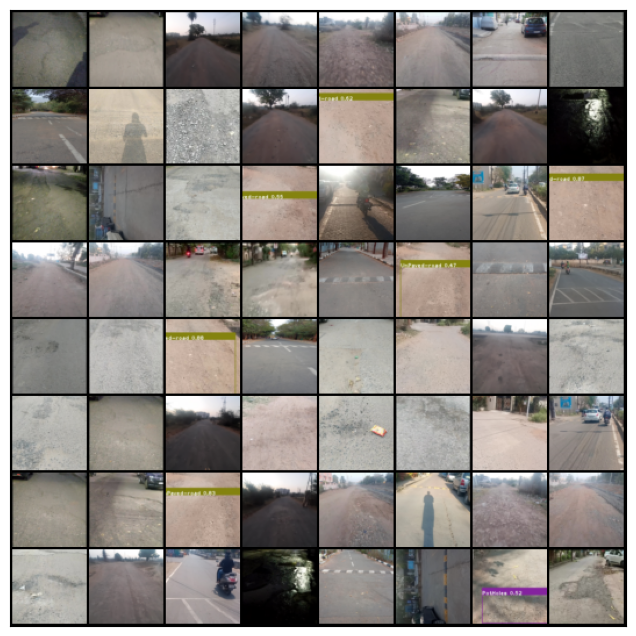

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

**Discriminator **

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
discriminator = to_device(discriminator, device)

## Generator

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

torch.Size([128, 3, 64, 64])


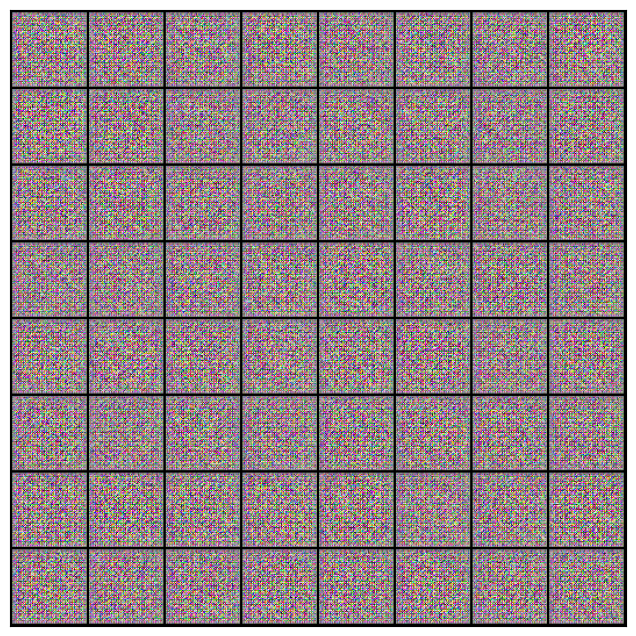

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
  #clear discriminator gradients
  opt_d.zero_grad()

  #pass real images through discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  #generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  #pass fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  #updating discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
  #clear generator gradients
  opt_g.zero_grad()

  #generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  #discriminator classification
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  #update generator weights
  loss.backward()
  opt_g.step()

  return loss.item()

In [ ]:
from torchvision.utils import save_image


In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print('Saving', fake_fname)
  if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


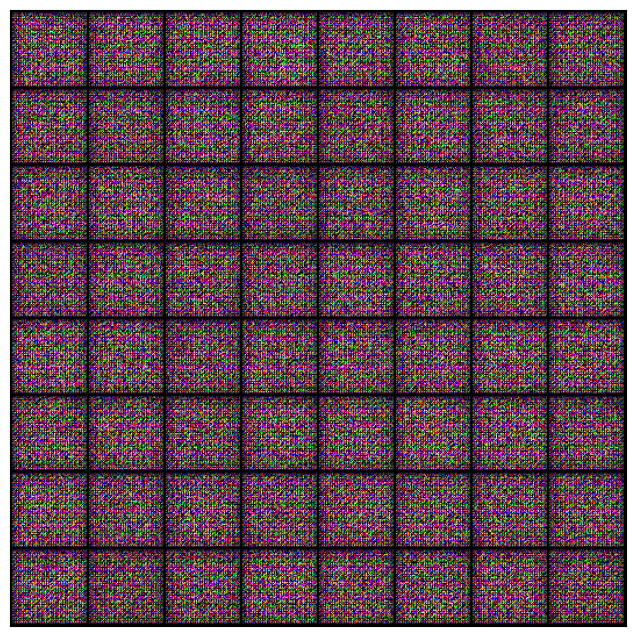

In [ ]:
save_samples(0, fixed_latent)

### **Training Loop**

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
  torch.cuda.empty_cache()
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        save_samples(epoch+start_idx, fixed_latent, show=False)
  return losses_g, losses_d, real_scores, fake_scores


In [ ]:
lr = 0.0002
epochs = 25

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 11.1368, loss_d: 0.0297, real_score: 0.9718, fake_score: 0.0001
Saving generated-images-0001.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 5.7222, loss_d: 0.0241, real_score: 0.9956, fake_score: 0.0193
Saving generated-images-0002.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 6.7510, loss_d: 0.1397, real_score: 0.9789, fake_score: 0.1055
Saving generated-images-0003.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 3.9250, loss_d: 0.3676, real_score: 0.8824, fake_score: 0.1911
Saving generated-images-0004.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 2.5757, loss_d: 0.3933, real_score: 0.7274, fake_score: 0.0384
Saving generated-images-0005.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 2.6469, loss_d: 0.3603, real_score: 0.7590, fake_score: 0.0520
Saving generated-images-0006.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 4.3576, loss_d: 0.5246, real_score: 0.9365, fake_score: 0.3390
Saving generated-images-0007.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 2.1910, loss_d: 0.5558, real_score: 0.6492, fake_score: 0.0752
Saving generated-images-0008.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 3.8874, loss_d: 0.8034, real_score: 0.8407, fake_score: 0.4097
Saving generated-images-0009.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 2.2083, loss_d: 0.3971, real_score: 0.7281, fake_score: 0.0485
Saving generated-images-0010.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 3.5386, loss_d: 0.2149, real_score: 0.8439, fake_score: 0.0309
Saving generated-images-0011.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 3.3971, loss_d: 0.4565, real_score: 0.8886, fake_score: 0.2552
Saving generated-images-0012.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 4.1142, loss_d: 0.3525, real_score: 0.8978, fake_score: 0.1923
Saving generated-images-0013.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 3.0620, loss_d: 0.5728, real_score: 0.8837, fake_score: 0.3310
Saving generated-images-0014.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 2.3067, loss_d: 0.3923, real_score: 0.8058, fake_score: 0.1313
Saving generated-images-0015.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 4.2964, loss_d: 0.4179, real_score: 0.9237, fake_score: 0.2687
Saving generated-images-0016.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 4.0852, loss_d: 0.7909, real_score: 0.4982, fake_score: 0.0024
Saving generated-images-0017.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 2.3997, loss_d: 0.4066, real_score: 0.7255, fake_score: 0.0448
Saving generated-images-0018.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 3.2856, loss_d: 0.3822, real_score: 0.9191, fake_score: 0.2391
Saving generated-images-0019.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 2.8576, loss_d: 0.2541, real_score: 0.8080, fake_score: 0.0248
Saving generated-images-0020.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 4.3357, loss_d: 0.5097, real_score: 0.6668, fake_score: 0.0337
Saving generated-images-0021.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 3.2507, loss_d: 0.7062, real_score: 0.9272, fake_score: 0.4281
Saving generated-images-0022.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 5.8157, loss_d: 0.1697, real_score: 0.8535, fake_score: 0.0022
Saving generated-images-0023.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 1.4860, loss_d: 1.0245, real_score: 0.4188, fake_score: 0.0179
Saving generated-images-0024.png


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 4.0766, loss_d: 0.4052, real_score: 0.8419, fake_score: 0.1931
Saving generated-images-0025.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
from IPython.display import Image

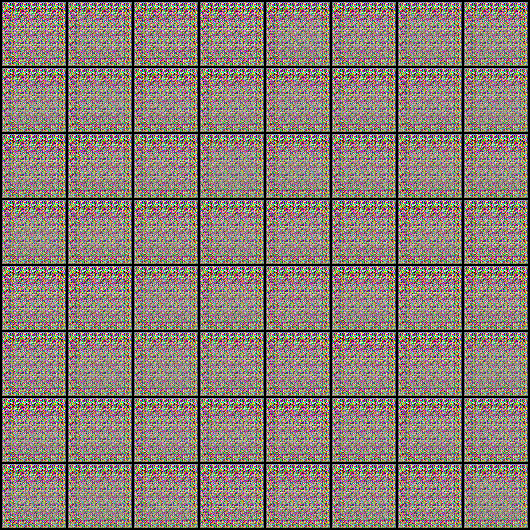

In [ ]:
Image('./generated/generated-images-0001.png')

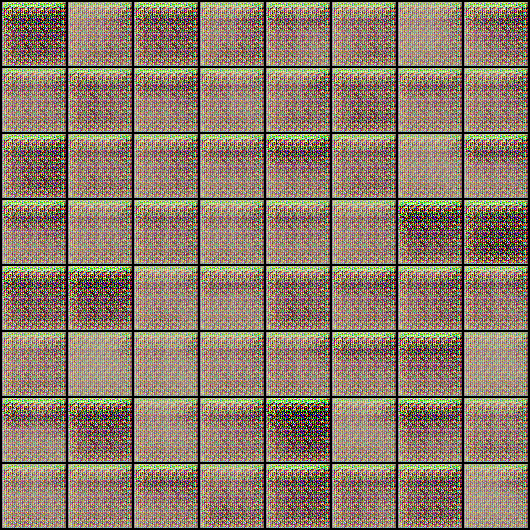

In [ ]:
Image('./generated/generated-images-0002.png')

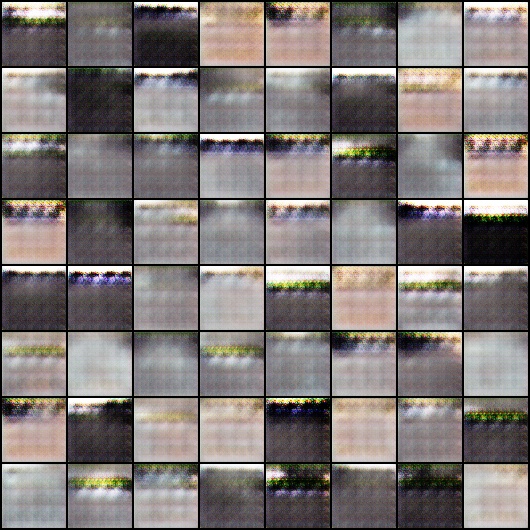

In [ ]:
Image('./generated/generated-images-0010.png')

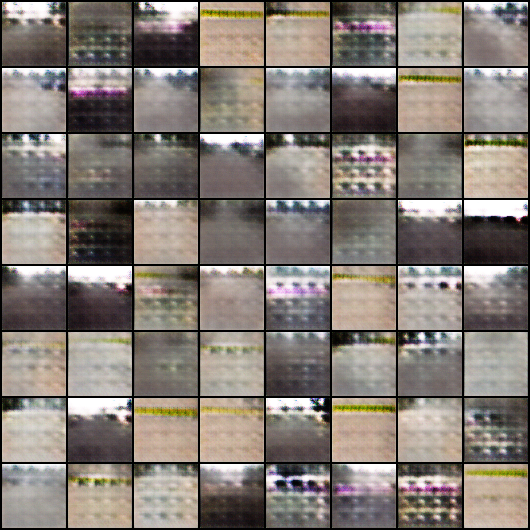

In [ ]:
Image('./generated/generated-images-0020.png')

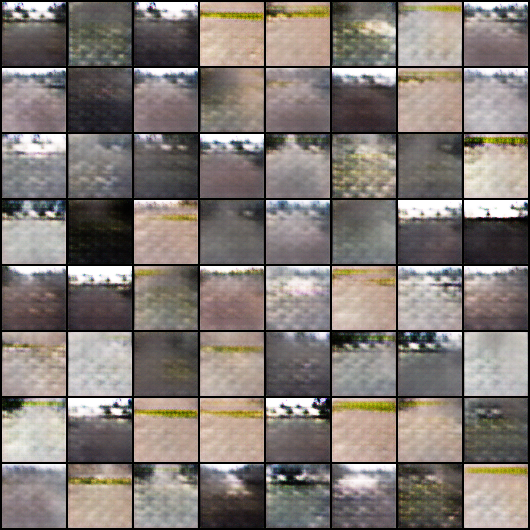

In [ ]:
Image('./generated/generated-images-0025.png')

In [ ]:
Image('./generated/generated-images-0030.png')

In [ ]:
Image('./generated/generated-images-0040.png')

In [ ]:
Image('./generated/generated-images-0045.png')

In [ ]:
Image('./generated/generated-images-0050.png')